# DQN para FrozenLake
### Librerías

In [33]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

### Modelo DQN

In [34]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

### Funciones auxiliares

In [35]:
def one_hot_state(state, state_space):
    one_hot = np.zeros(state_space)
    one_hot[state] = 1
    return one_hot

def select_action(model, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state)
            q_values = model(state_tensor)
            return torch.argmax(q_values).item()

### Hiperparámetros

In [36]:
env = gym.make('FrozenLake-v1', is_slippery=False)

state_space = env.observation_space.n
action_space = env.action_space.n

GAMMA = 0.99
LEARNING_RATE = 0.001
MEMORY_SIZE = 10000
BATCH_SIZE = 32
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01
EPISODES = 50000
TARGET_UPDATE_FREQ = 10

### Agente

In [37]:
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.policy_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = deque(maxlen=MEMORY_SIZE)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, epsilon):
        return select_action(self.policy_net, state, epsilon)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones)

        current_q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1)[0].detach()
        expected_q_values = rewards + (1 - dones) * GAMMA * next_q_values

        loss = nn.MSELoss()(current_q_values.squeeze(), expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### Entrenamiento

In [38]:
agent = DQNAgent(state_space, action_space)
epsilon = 1.0
rewards_history = []
epsilons_history=[]

for episode in range(EPISODES):
    state = env.reset()
    state = one_hot_state(state, state_space)
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        next_state = one_hot_state(next_state, state_space)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay()

    rewards_history.append(total_reward)

    if episode % TARGET_UPDATE_FREQ == 0:
        agent.update_target_network()

    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)
    epsilons_history.append(epsilon)

    if episode % 100 == 0:
        print(f"Episodio: {episode}, Recompensa: {total_reward}, Epsilon: {epsilon:.2f}")


Episodio: 0, Recompensa: 0.0, Epsilon: 0.99
Episodio: 100, Recompensa: 0.0, Epsilon: 0.60
Episodio: 200, Recompensa: 0.0, Epsilon: 0.37
Episodio: 300, Recompensa: 0.0, Epsilon: 0.22
Episodio: 400, Recompensa: 0.0, Epsilon: 0.13
Episodio: 500, Recompensa: 0.0, Epsilon: 0.08
Episodio: 600, Recompensa: 0.0, Epsilon: 0.05
Episodio: 700, Recompensa: 0.0, Epsilon: 0.03
Episodio: 800, Recompensa: 0.0, Epsilon: 0.02
Episodio: 900, Recompensa: 0.0, Epsilon: 0.01
Episodio: 1000, Recompensa: 1.0, Epsilon: 0.01
Episodio: 1100, Recompensa: 1.0, Epsilon: 0.01
Episodio: 1200, Recompensa: 1.0, Epsilon: 0.01
Episodio: 1300, Recompensa: 1.0, Epsilon: 0.01
Episodio: 1400, Recompensa: 1.0, Epsilon: 0.01
Episodio: 1500, Recompensa: 1.0, Epsilon: 0.01
Episodio: 1600, Recompensa: 1.0, Epsilon: 0.01
Episodio: 1700, Recompensa: 1.0, Epsilon: 0.01
Episodio: 1800, Recompensa: 1.0, Epsilon: 0.01
Episodio: 1900, Recompensa: 1.0, Epsilon: 0.01
Episodio: 2000, Recompensa: 1.0, Epsilon: 0.01
Episodio: 2100, Recompens

### Resultados


% de éxito últimos 100 episodios: 97.00%


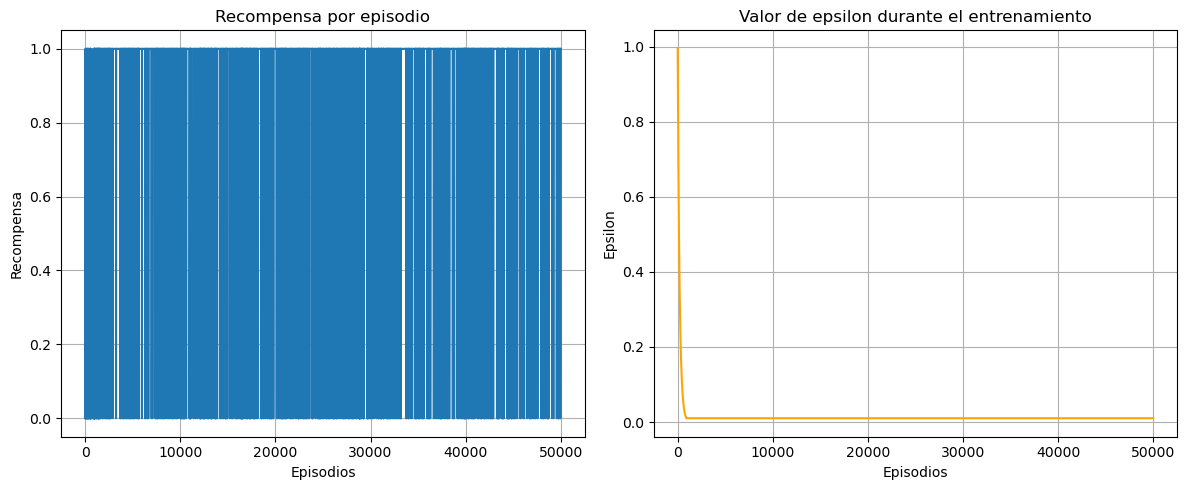

In [39]:
success_rate = sum(rewards_history[-100:]) / 100
print(f"\n% de éxito últimos 100 episodios: {success_rate:.2%}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_history)
plt.title("Recompensa por episodio")
plt.xlabel("Episodios")
plt.ylabel("Recompensa")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epsilons_history, color='orange')
plt.title('Valor de epsilon durante el entrenamiento')
plt.xlabel('Episodios')
plt.ylabel('Epsilon')
plt.grid(True)

plt.tight_layout()
plt.show()



### Visualización

In [56]:
env_video = gym.make('FrozenLake-v1', render_mode='rgb_array')
env_video = gym.wrappers.RecordVideo(env_video, video_folder="videos", name_prefix="frozenlake-dqn")

state = env_video.reset()
state = one_hot_state(state, state_space)
done = False

while not done:
    action = agent.act(state, epsilon=0)
    next_state, reward, done, _ = env_video.step(action)
    next_state = one_hot_state(next_state, state_space)
    state = next_state

env_video.close()

In [58]:
from IPython.display import Video
Video("videos/frozenlake-dqn-episode-0.mp4",embed=True)